# Phase 3 Artist Genre Prediction

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)
pd.options.display.max_colwidth = 100
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('data/data_w_genres.csv')

## Column Descriptions: 

**Acousticness**: The relative metric of the track being acoustic\
**Danceability**: The relative measurement of the track being danceable\
**Duration_MS**: The duration length of track (in ms)\
**Energy**: The energy of the track\
**Instrumentalness**: The relative ratio of the track being instrumental\
**Liveness**: The relative duration of the track sounding as a live performance\
**Loudness**: Relative loudness of the track in the typical range [-60, 0] in decibel (dB)\
**Speechiness**: The relative length of the track containing any kind of human voice\
**Tempo**: The tempo of the track in Beat Per Minute (BPM)\
**Valence**: The positivity of the track\
**Popularity**: The popularity of the song lately, default country = US\
**Key**: The primary key of the track encoded as integers in between 0 and 11\
**Mode**: The binary value representing whether the track starts with a major (1) chord progression or not (0)\
**Count**: The number of tracks from the original dataset, produced by the given artist (Dropped)


# Data Cleaning

### Removed all the empty genres

In [3]:
#This saves the enpty genres for predictions later on
df_pred=df.loc[df['genres'] == '[]']
df_pred = df_pred.reset_index()
df_pred = df_pred.drop('index',axis=1)

In [4]:
df = df.loc[df['genres'] != '[]']
df = df.reset_index()
df = df.drop('index',axis=1)

### First Iteration: Map data to Rap or country ###

In [5]:
df['rap'] = 0
df['country'] = 0
df['classical'] = 0
df['jazz'] = 0

In [6]:
count=0

for songs in df['genres']:
    song1 = songs.split(', ')
    for song in song1:
        if ' rap' in song and "trap" not in song and "country rap" not in song:
            df['rap'][count] += 1
        if "country" in song:
            df['country'][count] += 1
        if "classical" in song:
            df['classical'][count]+=1
        if "jazz" in song and 'jazz rap' not in song and 'classical jazz' not in song and 'country jazz' not in song:
            df['jazz'][count]+=1
    count+=1

<ipython-input-6-365487a95f8b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rap'][count] += 1
<ipython-input-6-365487a95f8b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['country'][count] += 1
<ipython-input-6-365487a95f8b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['classical'][count]+=1
<ipython-input-6-365487a95f8b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

### Further Categorize Rap or country

In [7]:
df = df[(df.rap >= 1) | (df.country >= 1) | (df.classical >= 1) | (df.jazz >= 1)]

In [8]:
df['clean_genres'] = df[['rap','country','classical','jazz']].idxmax(axis=1)

In [9]:
df[
    (df['classical'] >= 1) & (df['country'] >= 1) &
    ((df['country'] == df['classical']))
    ][['artists','genres', 'country', "classical", 'clean_genres']].sort_values(by=['classical'], ascending=False)

,artists,genres,country,classical,clean_genres


In [10]:
df[
    (df['classical'] >= 1) & (df['rap'] >= 1) &
    ((df['rap'] == df['classical']))
    ][['artists','genres', 'rap', "classical", 'clean_genres']].sort_values(by=['rap'], ascending=False)

,artists,genres,rap,classical,clean_genres


In [11]:
df[
    (df['country'] >= 1) & (df['rap'] >= 1) &
    ((df['country'] == df['rap']))
    ][['artists','genres', 'rap', "country", 'clean_genres']].sort_values(by=['rap'], ascending=False)

,artists,genres,rap,country,clean_genres
257,Adam Calhoun,"['country rap', 'military rap', 'redneck']",1,1,rap
13913,Rittz,"['atl hip hop', 'country rap', 'pop rap', 'southern hip hop']",1,1,rap


In [12]:
df[
    (df['jazz'] >= 1) & (df['rap'] >= 1) &
    ((df['jazz'] == df['rap']))
    ][['artists','genres', 'rap', "jazz", 'clean_genres']].sort_values(by=['rap'], ascending=False)

,artists,genres,rap,jazz,clean_genres
17827,Us3,"['electronica', 'jazz rap', 'nu jazz']",1,1,rap


In [13]:
df[
    (df['jazz'] >= 1) & (df['country'] >= 1) &
    ((df['jazz'] == df['country']))
    ][['artists','genres', 'country', "jazz", 'clean_genres']].sort_values(by=['country'], ascending=False)

,artists,genres,country,jazz,clean_genres
2016,"Blood, Sweat & Tears","['album rock', 'art rock', 'blues rock', 'brill building pop', 'classic rock', 'country rock', '...",1,1,country
4641,Dr. John,"['blues', 'blues rock', 'classic rock', 'country rock', 'electric blues', 'folk rock', 'funk', '...",1,1,country
7858,Jeff Beck,"['album rock', 'art rock', 'blues', 'blues rock', 'british blues', 'classic rock', 'country rock...",1,1,country
9923,Lonnie Johnson,"['acoustic blues', 'blues', 'country blues', 'jazz blues', 'louisiana blues', 'memphis blues', '...",1,1,country


In [14]:
df[
    (df['jazz'] >= 1) & (df['classical'] >= 1) &
    ((df['jazz'] == df['classical']))
    ][['artists','genres', 'classical', "jazz", 'clean_genres']].sort_values(by=['classical'], ascending=False)

,artists,genres,classical,jazz,clean_genres
4954,Egberto Gismonti,"['bossa nova', 'brazilian contemporary classical', 'brazilian jazz', 'ecm-style jazz', 'latin cl...",2,2,classical
938,Anja Lechner,"['classical cello', 'ecm-style jazz']",1,1,classical
1677,Benny Andersson,"['classic swedish pop', 'neo-classical', 'swedish jazz']",1,1,classical
8049,Jimmy Hamilton,"['classical clarinet', 'jazz clarinet']",1,1,classical
9799,Liquid Tension Experiment,"['instrumental rock', 'jazz metal', 'neo classical metal', 'progressive metal', 'shred']",1,1,classical
11796,Münir Nurettin Selçuk,"['turkish classical', 'turkish jazz']",1,1,classical
14401,Safiye Ayla,"['turkish classical', 'turkish jazz']",1,1,classical
15537,Steve Morse,"['instrumental rock', 'jazz fusion', 'neo classical metal', 'shred']",1,1,classical
16049,Tension,"['instrumental rock', 'jazz metal', 'neo classical metal', 'progressive metal', 'shred']",1,1,classical


In [15]:
df['clean_genres'][257] = "country"
df['clean_genres'][13913] = "rap"
df['clean_genres'][17827] = "rap"
df['clean_genres'][2016] = "country"
df['clean_genres'][4641] = "jazz"
df['clean_genres'][7858] = "jazz"
df['clean_genres'][9923] = "jazz"
df['clean_genres'][4954] = "jazz"
df['clean_genres'][938] = "classical"
df['clean_genres'][1677] = "classical"
df['clean_genres'][8049] = "jazz"
df['clean_genres'][9799] = "jazz"
df['clean_genres'][11796] = "classical"
df['clean_genres'][14401] = "classical"
df['clean_genres'][15537] = "jazz"
df['clean_genres'][16049] = "jazz"

<ipython-input-15-030fec7978d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_genres'][257] = "country"
<ipython-input-15-030fec7978d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_genres'][13913] = "rap"
<ipython-input-15-030fec7978d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_genres'][17827] = "rap"
<ipython-input-15-030fec7978d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a

In [16]:
df['duration_sec'] = round(df['duration_ms']/1000,2)

In [17]:
df[['artists','genres','rap','country','classical', 'jazz','clean_genres']][(df.rap > 2) | (df['country'] > 3) | (df['classical'] > 2) | (df['jazz'] > 2)]

,artists,genres,rap,country,classical,jazz,clean_genres
91,5th Ward Boyz,"['dirty south rap', 'dirty texas rap', 'gangster rap', 'houston rap']",4,0,0,0,rap
194,Aaron Copland,"['american modern classical', 'classical', 'early modern classical']",0,0,3,0,classical
197,Aaron Lewis,"['contemporary country', 'country', 'country road', 'modern country rock', 'outlaw country', 're...",0,5,0,0,country
204,Aaron Watson,"['contemporary country', 'country', 'country road', 'modern country rock', 'texas country']",0,5,0,0,country
236,Ace,"['dirty south rap', 'gangster rap', 'hip hop', 'miami hip hop', 'pop rap', 'rap', 'southern hip ...",3,0,0,0,rap
...,...,...,...,...,...,...,...
18727,Zoot Sims,"['bebop', 'contemporary post-bop', 'cool jazz', 'hard bop', 'jazz', 'jazz saxophone', 'soul jazz...",0,0,0,4,jazz
18771,convolk,"['dark trap', 'emo rap', 'melodic rap', 'sad rap']",3,0,0,0,rap
18807,ilyTOMMY,"['emo rap', 'sad rap', 'viral rap']",3,0,0,0,rap
18834,"nothing,nowhere.","['emo rap', 'pop rap', 'sad rap']",3,0,0,0,rap


## Basic EDA

In [18]:
genres_df = df.copy()
genres_df.reset_index(inplace=True)

In [19]:
genres_df = genres_df.drop('index', axis=1)

In [20]:
## dropped count because it is the count of songs that the artist has in the dataset
genres_df.drop('count', axis=1, inplace=True)

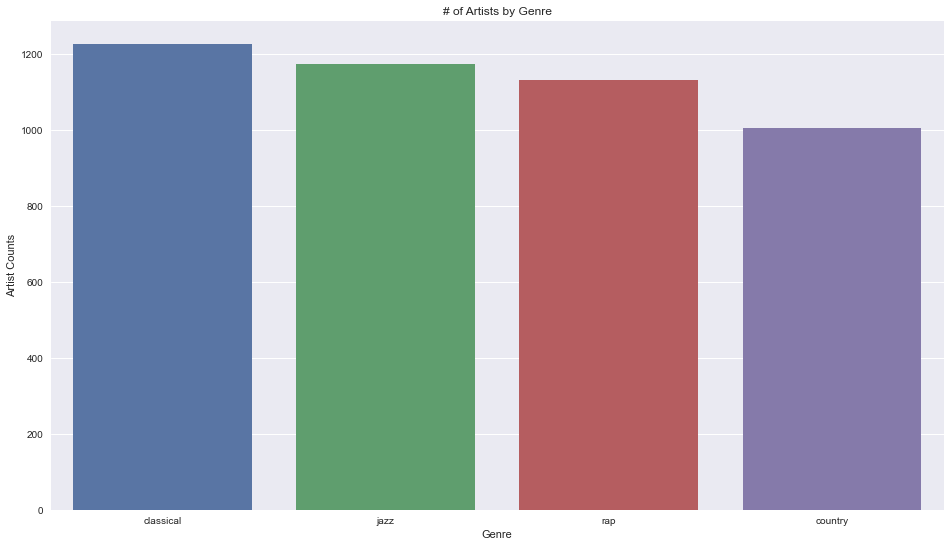

In [21]:
#number of artists per genre

fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(x=genres_df.clean_genres.value_counts().index, y=genres_df.clean_genres.value_counts().values);
ax.set_ylabel('Artist Counts')
ax.set_xlabel('Genre')
ax.set_title('# of Artists by Genre');

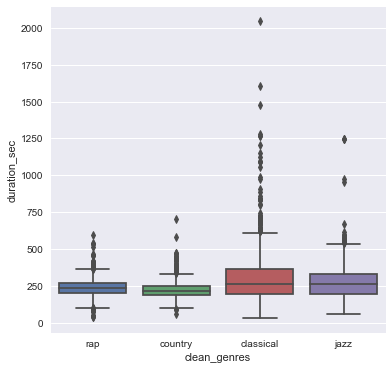

In [22]:
## distribution of duration by each genre

fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(x=genres_df.clean_genres,y=genres_df.duration_sec);

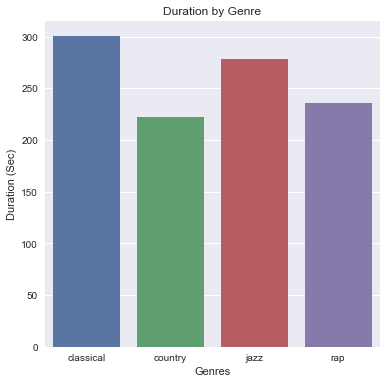

In [23]:
## Mean of duration for each genre
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x=genres_df.groupby('clean_genres')['duration_sec'].mean().index, y=genres_df.groupby('clean_genres')['duration_sec'].mean().values);
ax.set_ylabel("Duration (Sec)")
ax.set_xlabel("Genres")
ax.set_title('Duration by Genre');

Text(0.5, 1.0, 'Popularity by Genre')

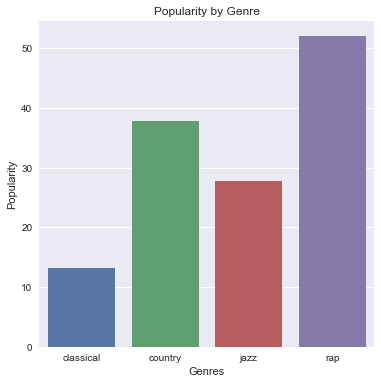

In [24]:
## Median of popularity for each genre
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x=genres_df.groupby('clean_genres')['popularity'].median().index, y=genres_df.groupby('clean_genres')['popularity'].median().values);
ax.set_ylabel("Popularity")
ax.set_xlabel("Genres")
ax.set_title('Popularity by Genre')

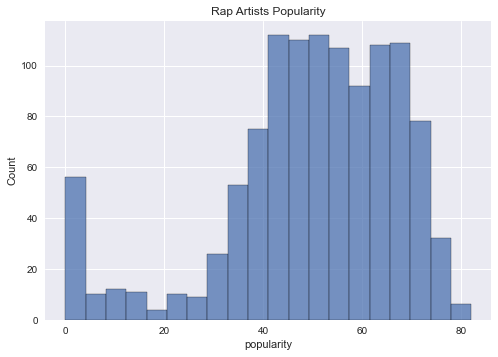

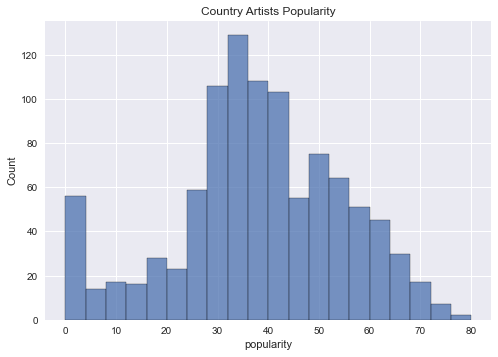

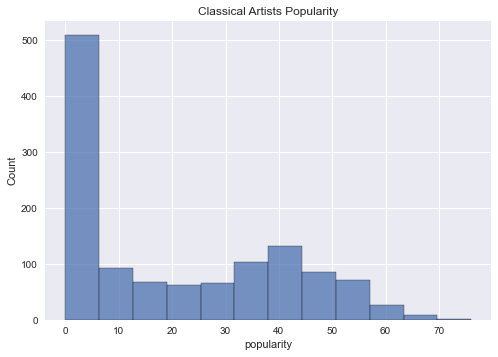

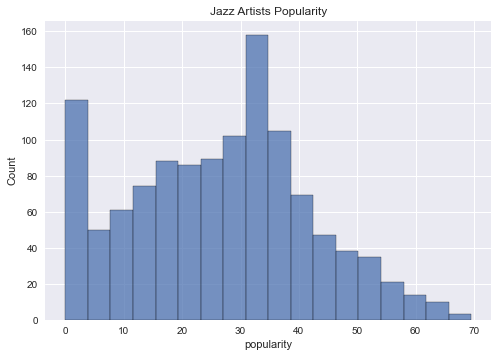

In [25]:
plot1 = plt.figure(1)
sns.histplot(genres_df[genres_df.clean_genres == 'rap'].popularity).set_title("Rap Artists Popularity")

plot2 = plt.figure(2)
sns.histplot(genres_df[genres_df.clean_genres == 'country'].popularity).set_title("Country Artists Popularity")

plot3 = plt.figure(3)
sns.histplot(genres_df[genres_df.clean_genres == 'classical'].popularity).set_title("Classical Artists Popularity")

plot4 = plt.figure(4)
sns.histplot(genres_df[genres_df.clean_genres == 'jazz'].popularity).set_title("Jazz Artists Popularity")



plt.show()

In [26]:
genres_df = pd.get_dummies(data=genres_df,columns=['key'],drop_first=True)

In [27]:
conditons = [genres_df['clean_genres'] == 'rap' ,
             genres_df['clean_genres'] == 'country',
             genres_df['clean_genres'] == 'classical',
             genres_df['clean_genres'] == 'jazz'
]

choices = [0,
           1,
           2,
           3
           
]

genres_df['clean_genres'] = np.select(conditons, choices)

In [28]:
y = genres_df['clean_genres']
artists = genres_df['artists']

In [29]:
#Drops the target value from the X df, and also removes multicollierity columns
X = genres_df.drop(columns = ['genres','clean_genres','rap','country','classical','jazz', 'duration_ms','artists'])

In [30]:
genres_df.drop(columns=['rap','country','classical','jazz','duration_ms']).corr()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,mode,clean_genres,duration_sec,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
acousticness,1.000000,-0.640637,-0.852734,0.474671,-0.057362,-0.742169,-0.352251,-0.303287,-0.443461,-0.495514,0.130139,0.577749,0.105000,-0.149881,0.046242,0.123078,-0.013442,0.124670,-0.075400,0.024478,0.002481,-0.016906,0.009778,-0.140107
danceability,-0.640637,1.000000,0.598596,-0.438412,-0.043839,0.643984,0.457486,0.213374,0.637346,0.394512,-0.121580,-0.447665,-0.256139,0.138757,-0.100284,-0.095755,-0.014861,-0.035423,0.058113,-0.021258,0.020706,-0.035722,0.019286,0.099902
energy,-0.852734,0.598596,1.000000,-0.477266,0.171266,0.865607,0.304125,0.355211,0.588328,0.369784,-0.107584,-0.470329,-0.116576,0.088512,-0.043957,-0.103642,-0.000787,-0.087335,0.079946,-0.007067,0.000960,0.024292,-0.014478,0.114901
instrumentalness,0.474671,-0.438412,-0.477266,1.000000,-0.126352,-0.600671,-0.296504,-0.155957,-0.374890,-0.309842,-0.021186,0.456556,0.235983,-0.060178,0.023987,0.065968,-0.024963,0.020497,-0.050661,0.008832,-0.007205,0.014196,0.013709,-0.067225
liveness,-0.057362,-0.043839,0.171266,-0.126352,1.000000,0.142570,0.140124,0.022637,0.060864,-0.147958,0.027486,-0.032673,0.021153,-0.021108,0.015890,-0.023685,-0.018537,0.034685,0.021112,-0.031552,0.015441,0.014979,-0.009154,-0.004973
loudness,-0.742169,0.643984,0.865607,-0.600671,0.142570,1.000000,0.301038,0.328462,0.551588,0.335458,-0.066460,-0.454822,-0.150877,0.079084,-0.050550,-0.089361,0.001063,-0.047795,0.070428,-0.018898,0.009341,-0.004046,-0.002010,0.088273
speechiness,-0.352251,0.457486,0.304125,-0.296504,0.140124,0.301038,1.000000,0.067932,0.191893,0.243484,-0.109142,-0.465579,-0.108829,0.184851,-0.060768,-0.060835,0.000277,-0.063876,0.076009,-0.059099,0.011802,-0.060317,0.035175,0.092526
tempo,-0.303287,0.213374,0.355211,-0.155957,0.022637,0.328462,0.067932,1.000000,0.280975,0.150223,-0.006365,-0.162536,-0.128038,-0.002422,-0.008824,-0.020717,0.022357,-0.035659,0.011248,-0.019741,0.001925,0.046703,-0.012661,0.016407
valence,-0.443461,0.637346,0.588328,-0.374890,0.060864,0.551588,0.191893,0.280975,1.000000,0.163200,-0.026051,-0.168948,-0.249777,-0.024877,-0.062354,-0.072059,-0.011965,0.027206,0.038647,0.041060,-0.004115,0.022224,-0.008212,0.033963
popularity,-0.495514,0.394512,0.369784,-0.309842,-0.147958,0.335458,0.243484,0.150223,0.163200,1.000000,-0.119744,-0.471184,-0.145586,0.136444,-0.020342,-0.049911,0.003248,-0.087693,0.055400,-0.006105,0.007185,-0.019864,-0.014243,0.093769


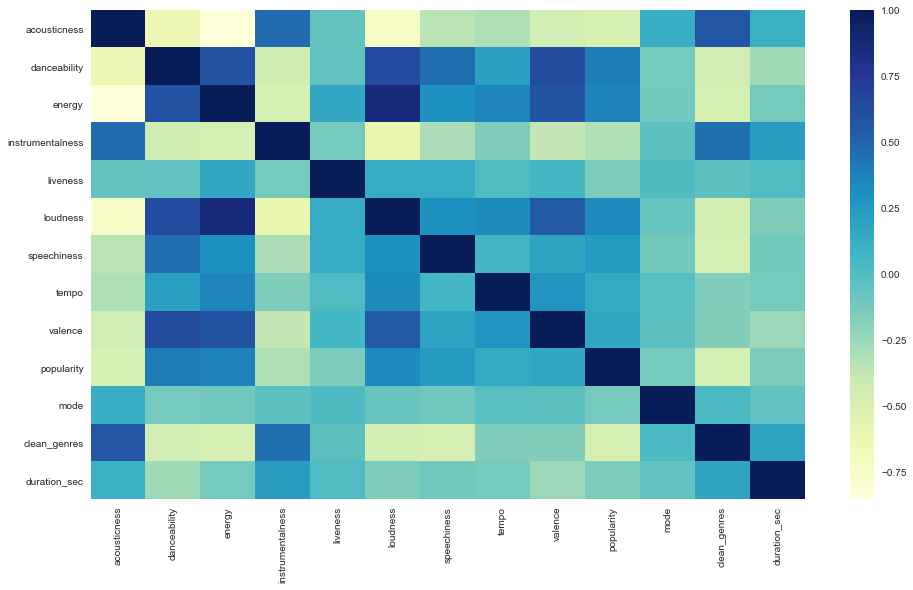

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(genres_df.drop(columns=['rap','country','classical','jazz','duration_ms','key_1','key_2','key_3','key_4','key_5','key_6','key_7','key_8','key_9','key_10','key_11',]).corr(),cmap="YlGnBu");

### Model 1 - Random Forest

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [33]:
rfc = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=1000)

In [34]:

params_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth':[None, 5,3],
    'min_samples_split':[2,10,20],
    'n_estimators': [100,1000,5000]
}
gridsearch_model = GridSearchCV(estimator=rfc,param_grid = params_grid,verbose=1,n_jobs=-1)

In [35]:
gridsearch_model.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  8.9min finished


GridSearchCV(estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 3],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [100, 1000, 5000]},
             verbose=1)

In [36]:
best_model_rf = gridsearch_model.best_estimator_

In [37]:
gridsearch_model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 2,
 'n_estimators': 5000}

In [38]:
best_model_rf

RandomForestClassifier(criterion='entropy', n_estimators=5000, n_jobs=-1,
                       random_state=42)

In [39]:
y_pred_rf = best_model_rf.predict(X_test)

In [40]:
y_preds_rf = pd.Series(y_pred_rf)

In [41]:
cf_matrix = confusion_matrix(y_test, y_preds_rf)

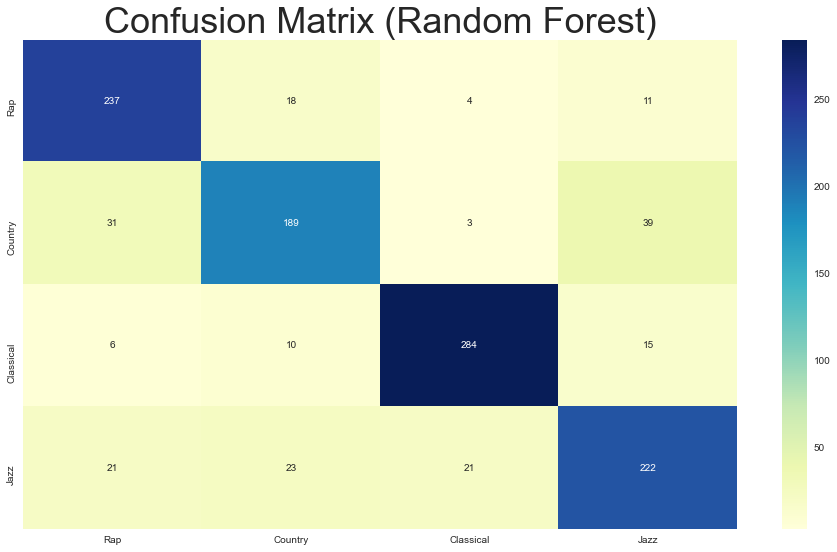

In [42]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu", fmt='g', 
            xticklabels=['Rap', 'Country', 'Classical', 'Jazz'], 
            yticklabels=['Rap', 'Country', 'Classical', 'Jazz'])
sns.set(font_scale=3)
ax.set_title('Confusion Matrix (Random Forest)');

In [43]:
f1_score(y_preds_rf,y_test,average='weighted')

0.8226146432655901

### Model 2 - KNN

In [44]:
knn = KNeighborsClassifier(n_jobs=-1)

In [45]:

params_grid = {
    'n_neighbors':[3,5,11,19],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}
gridsearch_model = GridSearchCV(estimator=knn,param_grid = params_grid,verbose=1,cv=3, n_jobs=-1)

In [46]:
gridsearch_model.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.7s finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [47]:
best_model_knn = gridsearch_model.best_estimator_

In [62]:
gridsearch_model.best_params_

{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}

In [48]:
best_model_knn

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=19,
                     weights='distance')

In [49]:
y_pred_knn = best_model_knn.predict(X_test)

In [50]:
y_preds_knn = pd.Series(y_pred_knn)

In [51]:
f1_score(y_preds_knn,y_test,average='weighted')

0.654829145641549

### Model 3 - XGBoost

In [52]:
grad_boost = xgboost.XGBRegressor(random_state=42, objective='multi:softmax',num_class=4)

grad_boost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_class=4, num_parallel_tree=1,
             objective='multi:softmax', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
y_pred_xg = grad_boost.predict(X_test)

In [54]:
f1_score(y_pred_xg,y_test,average='weighted')

0.8182810598456766

### Predictions

In [55]:
df_pred_genres = pd.get_dummies(data=df_pred,columns=['key'],drop_first=True)

In [56]:
pred_X = df_pred_genres.drop(columns = ['genres', 'duration_ms','artists'])

In [57]:
pred_y_pred_rf = best_model_rf.predict(pred_X)

In [58]:
pred_y_preds_rf = pd.Series(pred_y_pred_rf)

In [59]:
df_pred['preds'] = pred_y_preds_rf

In [60]:
conditons = [df_pred['preds'] == 0 ,
             df_pred['preds'] == 1,
             df_pred['preds'] == 2,
            df_pred['preds'] == 3
]

choices = ['rap',
           'country',
           'classical',
           'jazz'
           
]

df_pred['clean_genres'] = np.select(conditons, choices)

In [61]:
df_pred.iloc[[4971,12365,570,966]][['artists','clean_genres']]

,artists,clean_genres
4971,Hot Girl Meg,rap
12365,Trey Lewis,country
570,Andrew Andraos,classical
966,Avenue Blue (Featuring Jeff Golub),jazz
